In [2]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Import keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [4]:
# Download data
gs = yf.download("GS", "2020-01-01", "2024-10-1")

[*********************100%***********************]  1 of 1 completed


In [5]:
# Preprocess data
dataset_ex_df = gs.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

In [7]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7609.094, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7610.782, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7610.790, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7608.752, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7612.735, Time=0.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.388 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1194
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3803.376
Date:                Mon, 07 Oct 2024   AIC                           7608.752
Time:                        05:15:34   BIC                           7613.836
Sample:                             0   HQIC                          7610.668
               

In [8]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()

    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

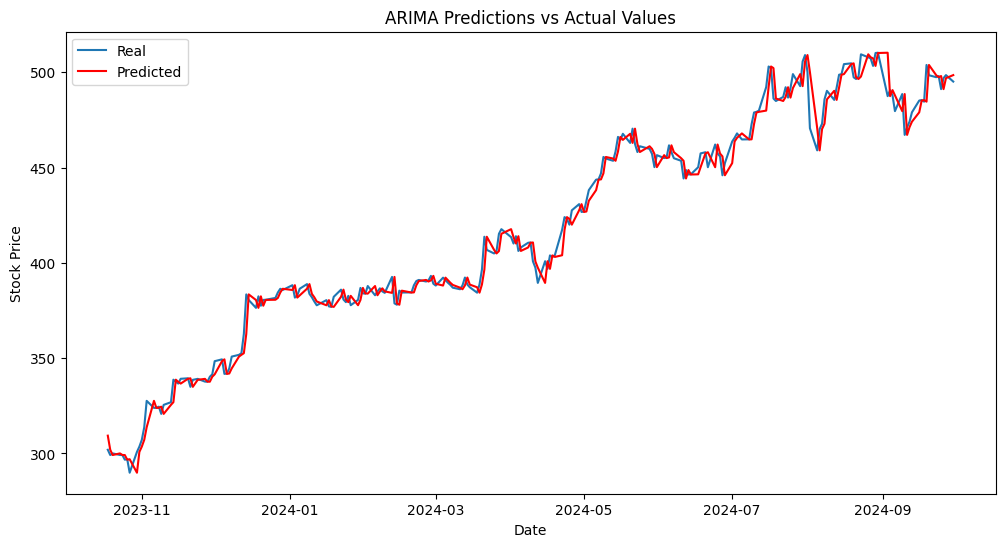

In [9]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


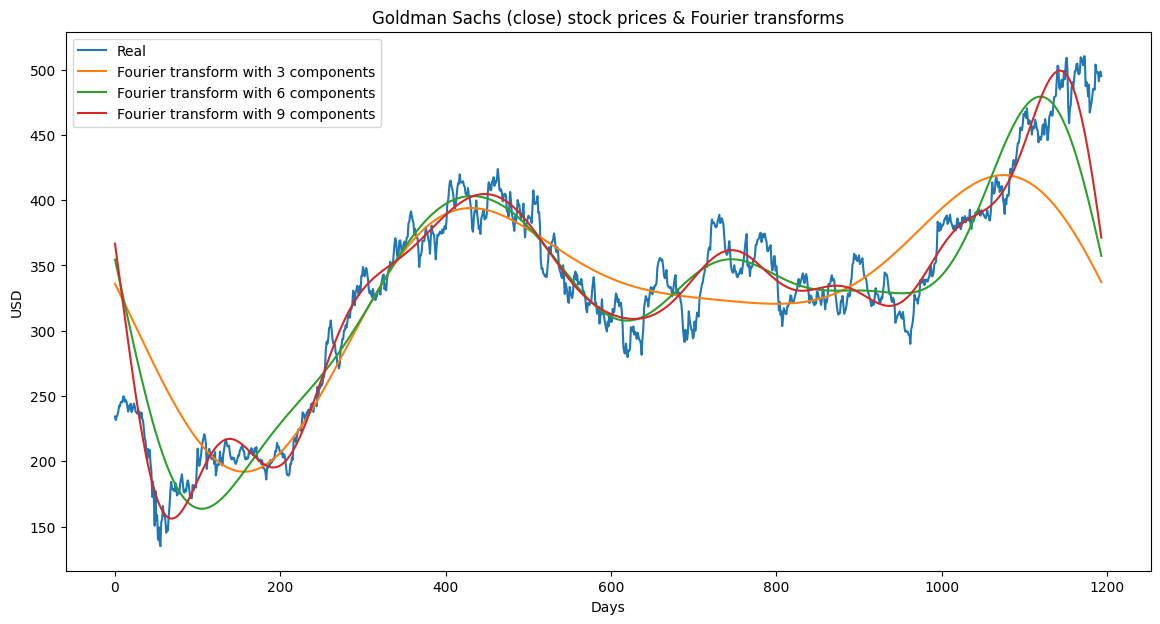

In [10]:
# Calculate the Fourier Transform
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [11]:
# Calculate EMA
def ema(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

# Calculate RSI
def rsi(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# Calculate MACD
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line

# Calculate OBV
def obv(close, volume):
    obv = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv

In [12]:
# Add technical indicators to dataset DF
dataset_ex_df['ema_20'] = ema(gs["Close"], 20)
dataset_ex_df['ema_50'] = ema(gs["Close"], 50)
dataset_ex_df['ema_100'] = ema(gs["Close"], 100)

dataset_ex_df['rsi'] = rsi(gs["Close"])
dataset_ex_df['macd'] = macd(gs["Close"])
dataset_ex_df['obv'] = obv(gs["Close"], gs["Volume"])

# Create arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset_ex_df.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset_ex_df[['ema_20', 'ema_50', 'ema_100', 'rsi', 'macd', 'obv', 'Close']]

# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

,ARIMA,Fourier_real,Fourier_imag,ema_20,ema_50,ema_100,rsi,macd,obv,Close
2020-01-23,245.580002,215.846167,4813.072552,241.892519,238.212029,236.447338,69.020247,3.430701,11449800,245.580002
2020-01-24,241.919998,-1123.590035,732.777758,241.895136,238.357440,236.555708,66.939695,2.998952,8572400,241.919998
2020-01-27,238.139999,-1278.047894,3632.297296,241.537504,238.348913,236.587080,56.561227,2.324972,6066200,238.139999
2020-01-28,242.580002,-1347.184046,157.400742,241.636789,238.514838,236.705752,60.177997,2.124618,9189200,242.580002
2020-01-29,240.119995,748.194498,2427.914788,241.492333,238.577785,236.773361,53.369501,1.747194,5477600,240.119995
...,...,...,...,...,...,...,...,...,...,...
2024-09-24,498.019989,3536.914423,-10048.365557,490.861183,486.381609,470.419208,54.252114,1.013368,31541500,498.019989
2024-09-25,491.140015,-2220.022680,-15405.488295,490.887738,486.568213,470.829521,51.793184,0.906218,29777600,491.140015
2024-09-26,496.920013,21440.584295,-23938.184024,491.462241,486.974166,471.346164,59.789632,1.273023,31155700,496.920013
2024-09-27,498.510010,4703.449667,-43592.910570,492.133457,487.426552,471.884062,56.132777,1.672736,32575800,498.510010


In [13]:
# Separate in Train and Test Dfs
train_size = int(len(merged_df) * 0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [14]:
# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values

In [15]:
# Define model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=False)

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 76911.6719 - val_loss: 178983.6406
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76637.3438 - val_loss: 178529.4375
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76381.6797 - val_loss: 177862.5156
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75972.5781 - val_loss: 176573.6250
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 75175.0312 - val_loss: 174185.4219
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 73819.2734 - val_loss: 170332.0469
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71568.5391 - val_loss: 163404.2500
Epoch 8/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67812.8203 - val_loss: 153521.1094
Epoch 9/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62711.2656 - val_loss: 140631.6562
Epoch 10/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56140.9180 - val_loss: 124274.8984
Epoch 11/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

In [16]:
y_pred = model.predict(X_test)

# Calculate test metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Mean Squared Error (MSE): 377.4476606796922
Mean Absolute Error (MAE): 9.00399133714579
R2 Score: 0.884557359727505
Explained Variance Score: 0.9000322683714328
Mean Absolute Percentage Error (MAPE): 15.65948733020665
Mean Percentage Error (MPE): -0.254314282980015


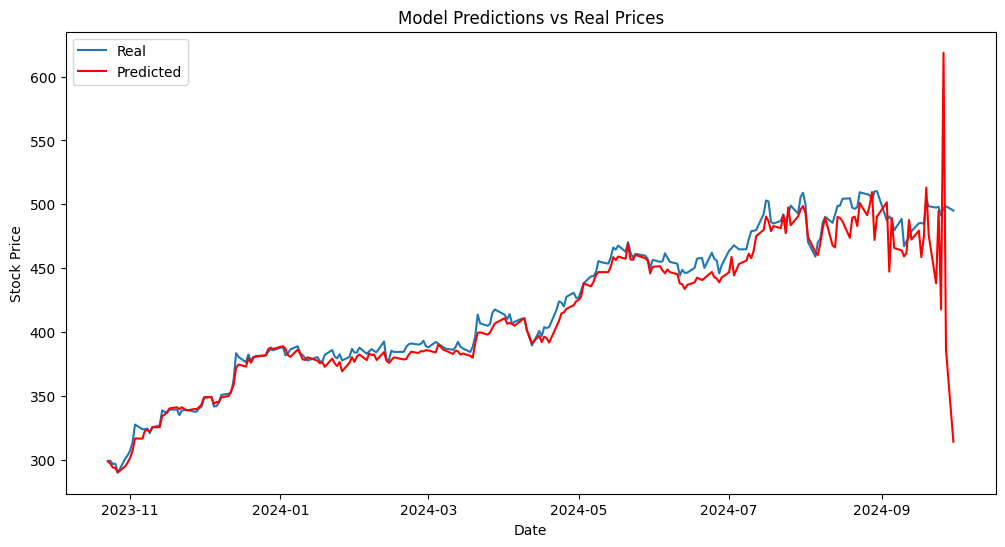

In [17]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()